In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls /content/gdrive/MyDrive/cat.jpg

### 0. 필요한 라이브러리 호출

In [69]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #  torch.cuda.is_available() GPU를 사용가능하면 True, 아니라면 False를 리턴
print("지금 사용하는 device :",device)

지금 사용하는 device : cuda:0


### 1. 신경망 생성, VGG_19 모델 사용

In [71]:
model = models.vgg19(pretrained=True) # vgg19를 불러온다
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [72]:
model.cpu() # 모델에 입력되는 이미지를 넘파이로 받아오는 부분때문에 CPU를 사용하도록 지정하였습니다
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### 2. 데이터셋 준비

torch.Size([1, 3, 100, 100])


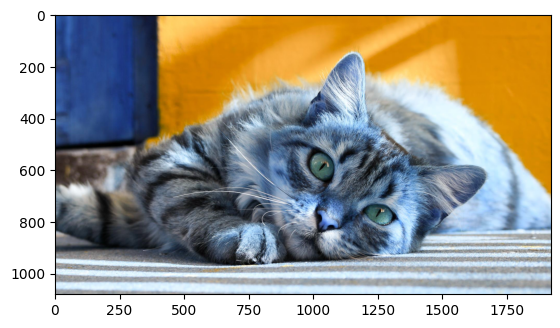

In [73]:
img = cv2.imread("./잡다한 파일/data/cat.jpg")

plt.imshow(img)
img = cv2.resize(img, (100,100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(img.shape)

1. img = cv2.resize(img, (100,100), interpolation=cv2.INTER_LINEAR) 설명
    - 첫번째 파라미터 : 변경할 이미지 파일
    - 두번째 파라미터 : 변경될 이미지 크기를 (너비, 높이)로 지정
    - interpolation : 보간법

이미지 크기를 변경할 경우 변형된 이미지 픽셀을 추정해서 값을 할당해야 합니다.

이미지 비율을 변경하면 존재하지 않은 영역에 새로운 픽셀 값을 매핑하거나 존재하는 픽셀들을 압축해서 새로운 값을 할당해야 합니다.

이러한 상황을 피하고자 이미지 상에 존재하는 픽셀 데이터(x,y)들에 대해 근사 함수 f(x,y)를 적용해서 새로운 픽셀 값을 구하는 것이 보간법입니다. 

### 3. 특성 맵을 확인하기 위한 클래스 정의

In [67]:
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()

    def remove(self):
        self.hook.remove()

### 4. 특성 맵 확인

In [76]:
result = LayerActivations(model.features, 0)

img.cpu()

model(img)
activations = result.features

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

IndexError: list index out of range

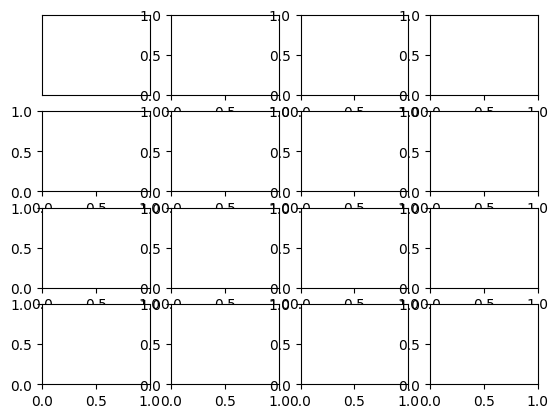

<Figure size 1200x800 with 0 Axes>

In [63]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()